<a href="https://colab.research.google.com/github/calebs15/mm2024/blob/main/Data_Scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####Adding Libraries

In [1]:
#add libraries we will need
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab.data_table import DataTable
DataTable.max_columns = 70

######Links To Get

In [ ]:
#all pages we will need
"""
https://www.ncaa.com/stats/basketball-men/d1/current/team/474 #assist/turnover ratio
https://www.ncaa.com/stats/basketball-men/d1/current/team/216 #apg
https://www.ncaa.com/stats/basketball-men/d1/current/team/1284 #bench points per game
https://www.ncaa.com/stats/basketball-men/d1/current/team/214 #blocks per game
https://www.ncaa.com/stats/basketball-men/d1/current/team/1288 #efg
https://www.ncaa.com/stats/basketball-men/d1/current/team/1285 #fastbreak
https://www.ncaa.com/stats/basketball-men/d1/current/team/148 #fg%
https://www.ncaa.com/stats/basketball-men/d1/current/team/149 #def fg%
https://www.ncaa.com/stats/basketball-men/d1/current/team/286 #fouls per game
https://www.ncaa.com/stats/basketball-men/d1/current/team/638 #ft attempts
https://www.ncaa.com/stats/basketball-men/d1/current/team/150 #ft%
https://www.ncaa.com/stats/basketball-men/d1/current/team/633 #ft made per game
https://www.ncaa.com/stats/basketball-men/d1/current/team/151 #rebound margin
https://www.ncaa.com/stats/basketball-men/d1/current/team/859 #drebpg
https://www.ncaa.com/stats/basketball-men/d1/current/team/857 #orebpg
https://www.ncaa.com/stats/basketball-men/d1/current/team/932 #totrebpg
https://www.ncaa.com/stats/basketball-men/d1/current/team/147 #scoring margin - includes ppg and oppg
https://www.ncaa.com/stats/basketball-men/d1/current/team/215 #steals
https://www.ncaa.com/stats/basketball-men/d1/current/team/625 #3pt attempts
https://www.ncaa.com/stats/basketball-men/d1/current/team/152 #3pt%
https://www.ncaa.com/stats/basketball-men/d1/current/team/518 #def 3pt%
https://www.ncaa.com/stats/basketball-men/d1/current/team/153 #3pts made per game
https://www.ncaa.com/stats/basketball-men/d1/current/team/519 #turnover margin
https://www.ncaa.com/stats/basketball-men/d1/current/team/931 #turnovers forced per game
https://www.ncaa.com/stats/basketball-men/d1/current/team/217 #turnovers per game
https://www.ncaa.com/stats/basketball-men/d1/current/team/168 #record and winning pct
"""



#####Scrape The Data

In [2]:
df_dict = {}
page_id_list = [474, 216, 1284, 214, 1288, 1285, 148, 149, 286, 638, 150, 633, 151, 859, 857, 932, 147, 215, 625, 152, 518, 153, 519, 931, 217, 168]
for id in page_id_list:
  df_dict[f"df_{id}"] = pd.DataFrame()

for id in page_id_list:
  name = f"df_{id}"
  url = f"https://www.ncaa.com/stats/basketball-men/d1/current/team/{id}"
  page = requests.get(url)
  soup = BeautifulSoup(page.text, 'html')
  table = soup.find('table')
  titles = soup.find_all('th')
  table_titles = [title.text for title in titles]
  df = pd.DataFrame(columns = table_titles)

  urlList = []
  for i in range(1,9):
    urlList.append(f"{url}/p{i}")

  for link in urlList:
    url = link
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html')
    table = soup.find('table')
    columnData = table.find_all('tr')

    for row in columnData[1:]:
      rowData = row.find_all('td')
      individualRowData = [data.text for data in rowData]
      length = len(df)
      df.loc[length] = individualRowData

  df_dict[f"df_{id}"] = pd.concat([df_dict[f"df_{id}"], df], ignore_index=True).drop_duplicates(subset = "Team", keep = "first").reset_index(drop = True)
  del df
  del urlList

#####Clean The Data

In [ ]:
master_df = None
for key, df in df_dict.items():
    if master_df is None:
        master_df = df
    else:
      df.columns = [col + '_' + key if col != "Team" else col for col in df.columns]
      master_df = pd.merge(master_df, df, on = "Team", how = "inner")

In [ ]:
#delete all rank  and games columns
filtered_master_df = master_df.filter(like = "GM", axis = 1)
filtered_master_df = master_df.filter(like = "Rank", axis = 1)
master_df = master_df.drop(columns = filtered_master_df.columns)
master_df = master_df.apply(pd.to_numeric, errors = "ignore")

In [ ]:
#create march madness teams only
march_madness_list = ["UConn", "Houston", "Purdue", "North Carolina", "Tennessee", "Arizona", "Marquette", "Iowa St.", "Baylor", "Creighton", "Kentucky", "Illinois", "Duke", "Kansas", "Auburn", "Alabama", "BYU",
                      "San Diego St.", "Wisconsin", "Saint Mary's (CA)", "Gonzaga", "Clemson", "Texas Tech", "South Carolina", "Florida", "Washington St.", "Texas", "Dayton", "Nebraska", "Utah St.", "Fla. Atlantic",
                      "Mississippi St.", "Michigan St.", "Texas A&M", "TCU", "Northwestern", "Nevada", "Boise St.", "Colorado", "Drake", "Virginia", "New Mexico", "Oregon", "Colorado St.", "NC State", "Duquesne",
                      "Grand Canyon", "James Madison", "McNeese", "UAB", "Vermont", "Yale", "Samford", "Col. of Charleston", "Oakland", "Akron", "Morehead St.", "Colgate", "Long Beach St.", "Western Ky.", "South Dakota St.",
                      "Saint Peter's", "Longwood", "Stetson", "Montana St.", "Grambling", "Howard", "Wagner"]

mm_df = master_df[master_df["Team"].isin(march_madness_list)]

#####First Attempts At Viz

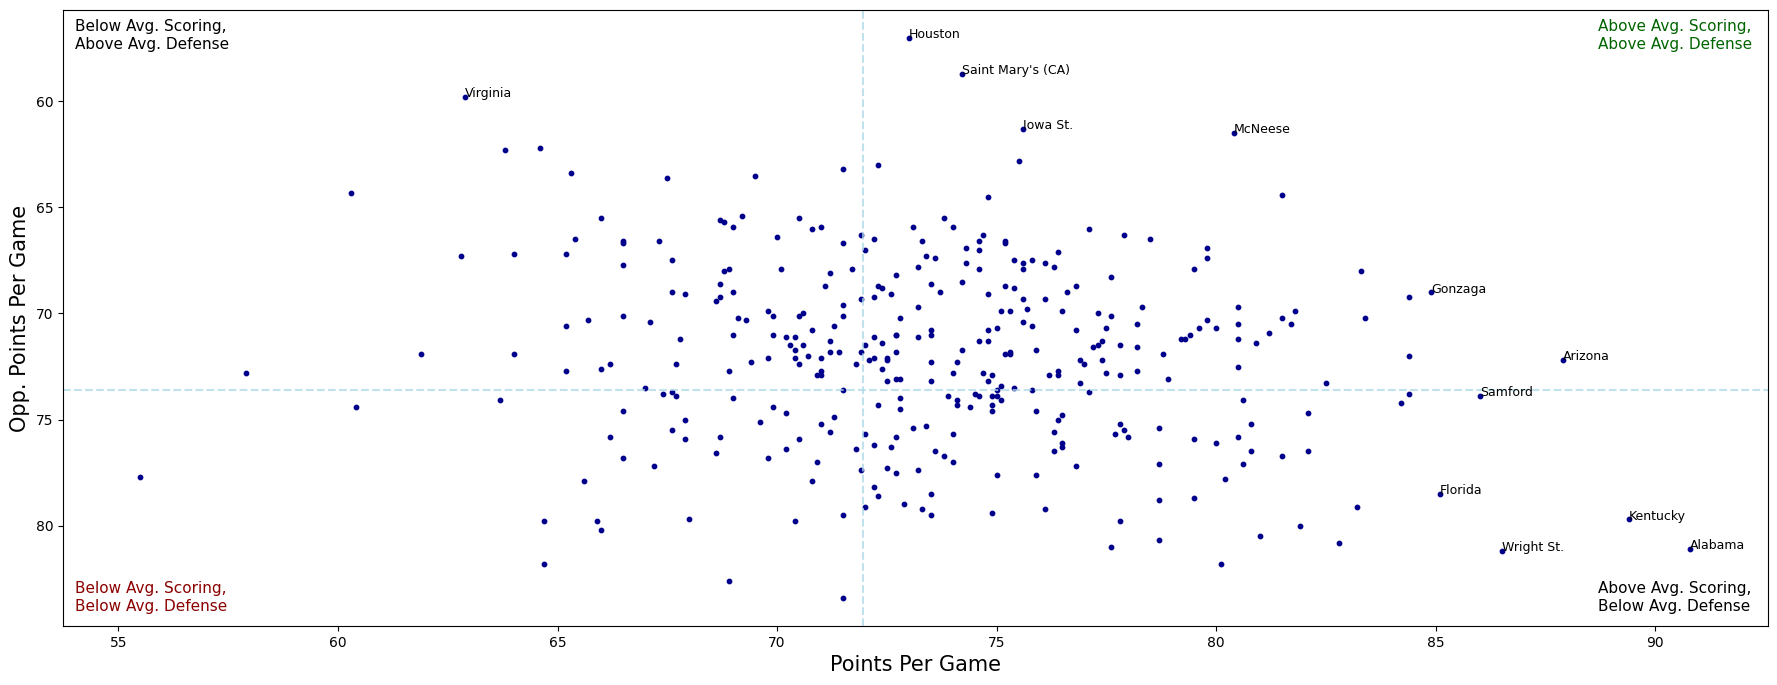

In [ ]:
#first attempt at graph
plt.scatter(x=master_df["PPG_df_147"], y=master_df["OPP PPG_df_147"], c = "darkblue", s = 10)
plt.xlabel("Points Per Game", fontsize = 15)
plt.gca().invert_yaxis()
plt.ylabel("Opp. Points Per Game", fontsize = 15)
plt.axhline(master_df["PPG_df_147"].mean(), color = "lightblue", linestyle= "--", alpha = 0.75)
plt.axvline(master_df["OPP PPG_df_147"].mean(), color = "lightblue", linestyle= "--", alpha = 0.75)
plt.text(54, 57.5, "Below Avg. Scoring, \nAbove Avg. Defense", fontsize = 11, color="black")
plt.text(88.7, 57.5, "Above Avg. Scoring, \nAbove Avg. Defense", fontsize = 11, color="darkgreen")
plt.text(54, 84, "Below Avg. Scoring, \nBelow Avg. Defense", fontsize = 11, color="darkred")
plt.text(88.7, 84, "Above Avg. Scoring, \nBelow Avg. Defense", fontsize = 11, color="black")
for index, row in master_df.iterrows():
  if (row["PPG_df_147"] - master_df["PPG_df_147"].mean()) > 11:
    plt.text(row["PPG_df_147"], row["OPP PPG_df_147"], row["Team"], fontsize=9, color="black")
  elif (master_df["OPP PPG_df_147"].mean() - row["OPP PPG_df_147"]) > 10:
    plt.text(row["PPG_df_147"], row["OPP PPG_df_147"], row["Team"], fontsize=9, color="black")




figure = plt.gcf()  # get current figure
figure.set_size_inches(22, 8)

plt.show()

In [ ]:
scoring_diff_fig = plt.figure(1)
plt.scatter(x=mm_df["PPG_df_147"], y=mm_df["OPP PPG_df_147"], c = "darkblue", s = 10)
plt.xlabel("Points Per Game", fontsize = 15)
plt.gca().invert_yaxis()
plt.ylabel("Opp. Points Per Game", fontsize = 15)
plt.axhline(mm_df["OPP PPG_df_147"].mean(), color = "lightblue", linestyle= "--", alpha = 0.75)
plt.axvline(mm_df["PPG_df_147"].mean(), color = "lightblue", linestyle= "--", alpha = 0.75)
for index, row in mm_df.iterrows():
  if (row["PPG_df_147"] - mm_df["PPG_df_147"].mean()) > 11:
    plt.text(row["PPG_df_147"], row["OPP PPG_df_147"], row["Team"], fontsize=9, color="black")
  elif (mm_df["OPP PPG_df_147"].mean() - row["OPP PPG_df_147"]) > 10:
    plt.text(row["PPG_df_147"], row["OPP PPG_df_147"], row["Team"], fontsize=9, color="black")


bench_ppg_fig = plt.figure(2)
sorted = mm_df[["Team", "PPG_df_1284"]].sort_values(by=["PPG_df_1284"], ascending = False)
plt.bar(sorted["Team"], sorted["PPG_df_1284"], color = "red")
plt.title("Bench Points Per Game")
plt.xticks(rotation = 90, fontsize = 10)


bench_ppg_fig.set_size_inches(22, 8)
plt.show()

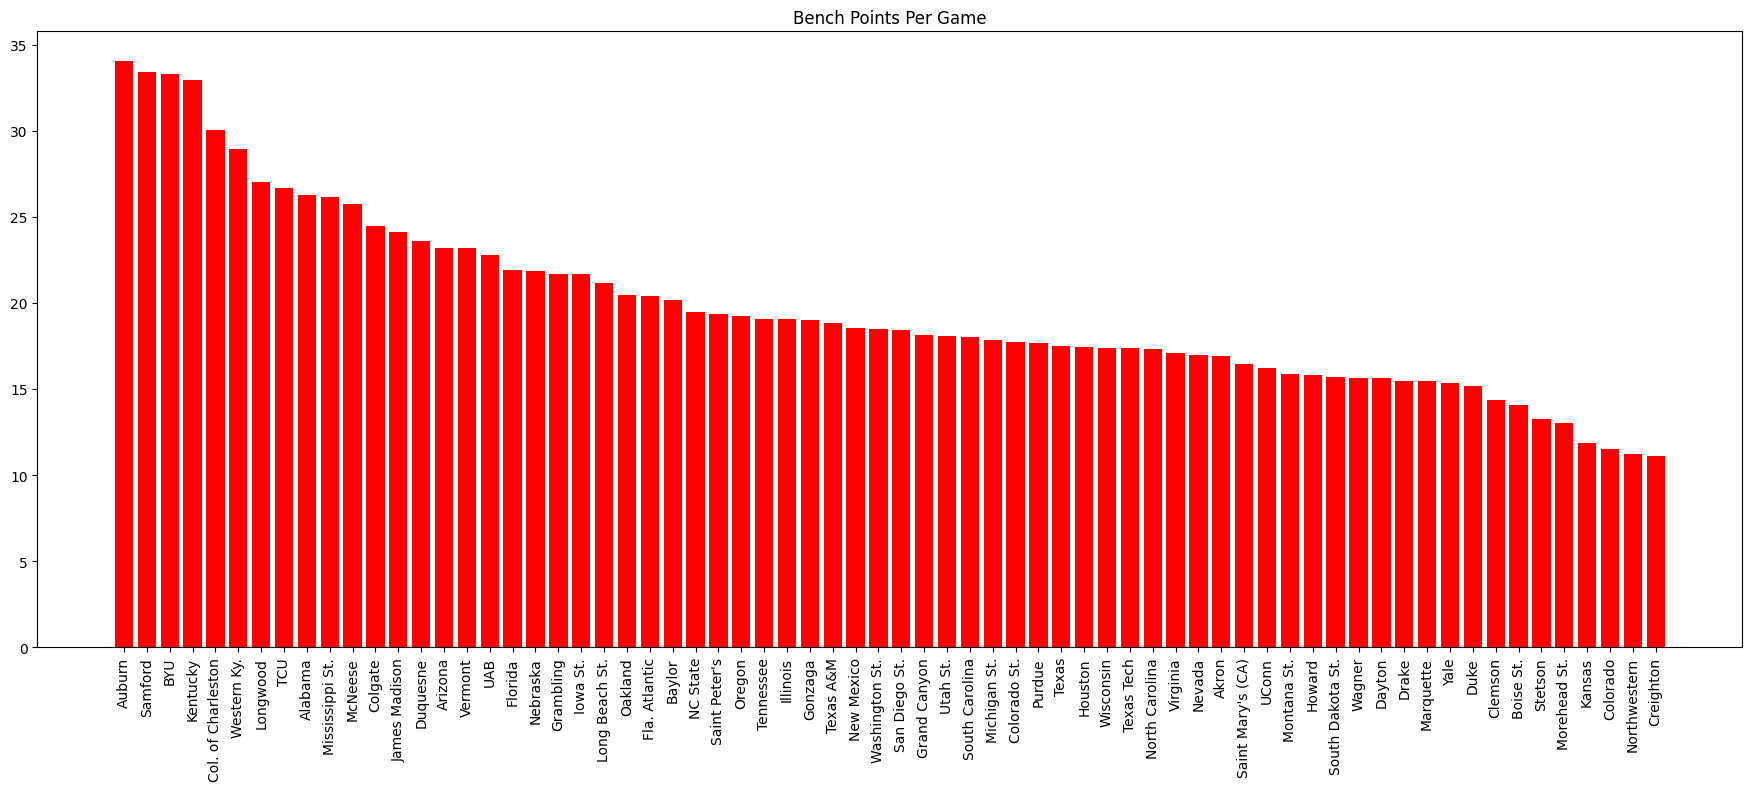

In [ ]:
bench_ppg_fig = plt.figure(2)
sorted = mm_df[["Team", "PPG_df_1284"]].sort_values(by=["PPG_df_1284"], ascending = False)
plt.bar(sorted["Team"], sorted["PPG_df_1284"], color = "red")
plt.title("Bench Points Per Game")
plt.xticks(rotation = 90, fontsize = 10)


bench_ppg_fig.set_size_inches(22, 8)
plt.show()

#####Import Cleaned Data

In [3]:
#downloading data to csv to clean it in excel
#mm_df.to_csv("/content/drive/MyDrive/Data Work/mm_df.csv")
#upload new file with extraneous info deleted
df_mm = pd.read_csv("https://raw.githubusercontent.com/calebs15/mm2024/main/mm_df.csv")
df_mm

,Team,GM,Asst/TO Ratio,APG,Bench PPG,BKPG,EFG%,Fastbreak PPG,FG%,OPP FG%,...,3PTAPG,3FG%,OPP 3FG%,3PTPG,TO Ratio,TO Forced PG,TOPG,W,L,W%
0,UConn,34,1.88,18.5,16.24,5.4,0.571,12.62,49.60,39.803,...,24.0,36.69,31.9,8.8,0.9,10.71,9.9,31,3,91.2
1,Virginia,33,1.86,15.2,17.36,5.1,0.493,5.36,43.36,40.159,...,18.1,36.29,30.4,6.6,3.8,11.97,8.2,23,10,69.7
2,Colorado St.,34,1.82,18.4,17.97,3.2,0.554,12.41,48.83,43.200,...,21.9,34.05,33.1,7.4,1.6,11.74,10.1,24,10,70.6
3,Northwestern,32,1.79,15.7,11.22,3.3,0.532,6.00,45.91,45.021,...,21.1,39.41,35.9,8.3,3.6,12.31,8.8,21,11,65.6
4,BYU,33,1.74,18.6,33.30,3.0,0.551,12.18,46.23,42.630,...,32.2,34.81,31.8,11.2,0.5,11.21,10.7,23,10,69.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,Grand Canyon,33,1.01,12.4,18.15,5.3,0.528,10.85,46.51,40.482,...,20.9,34.44,32.4,7.2,1.7,13.94,12.3,29,4,87.9
64,Western Ky.,33,0.97,13.2,28.94,3.2,0.522,13.70,46.79,41.253,...,20.1,33.99,31.6,6.8,0.5,14.24,13.7,22,11,66.7
65,Howard,34,0.89,13.9,15.97,2.9,0.524,8.85,45.12,44.646,...,21.6,37.38,33.6,8.1,-3.3,12.35,15.7,18,16,52.9
66,Saint Peter's,32,0.85,10.8,19.38,4.2,0.450,9.44,39.66,41.388,...,17.7,33.22,32.2,5.9,0.8,13.56,12.8,19,13,59.4


#####Second Attempts At Viz (Seaborn)

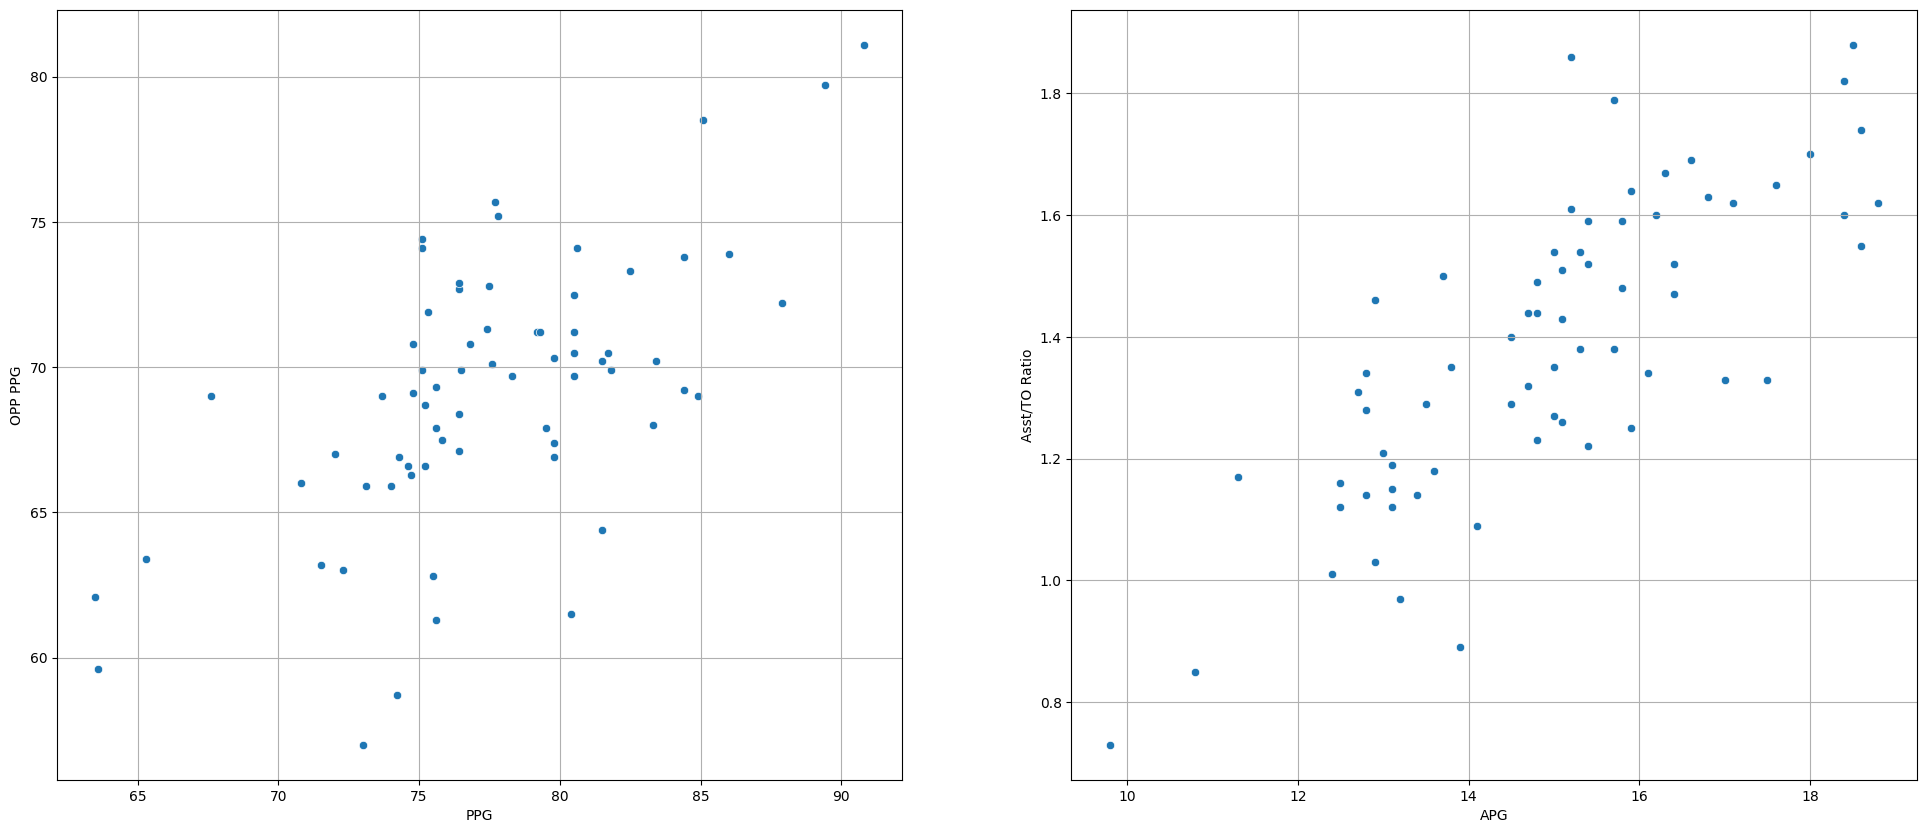

In [ ]:
import seaborn as sns

fig, axs = plt.subplots(ncols=2, figsize = (24,10))
sns.scatterplot(x='PPG', y='OPP PPG', data=df_mm, ax=axs[0])
sns.scatterplot(x='APG', y='Asst/TO Ratio', data=df_mm, ax=axs[1])

axs[0].grid(True)
axs[1].grid(True)

